<a href="https://colab.research.google.com/github/ashutoshrabia/EEGNet/blob/main/EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data prep and epoching

In [ ]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfreqz
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle

The butter_bandpass_filter function is designed to clean up Brain-Computer Interface (BCI) data by filtering out unwanted frequencies, allowing only the frequencies of interest to pass through.

**Sampling Frequency (fs)**: BCI data is collected at a certain rate, known as the sampling frequency. This function uses that rate to understand the time intervals of your data.

**Nyquist Frequency:** This is half of the sampling frequency and is important for digital signal processing. It helps in normalizing the cutoff frequencies.

In [ ]:
fs = 200.0     # 200 Hz sampling rate
lowcut = 1.0   # 0.1 Hz is the lowest frequency we will pass
highcut = 40.0 # 40 Hz is the highest frequency we will pass.


def butter_bandpass_filter(raw_data, fs, lowcut = 1.0, highcut = 40.0, order = 5):
  nyq = 0.5 * fs
  low = lowcut/nyq
  high = highcut/nyq
  sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
  filted_data = sosfiltfilt(sos, raw_data)
  return filted_data

**Epoch**: An epoch is a segment of data that typically corresponds to a specific event or stimulus in BCI experiments. In this case, the epoch starts at the stimulus (0 ms) and ends 700 ms after the stimulus.

**Baseline**: The baseline is a reference period used to normalize the data. It starts at the stimulus (0 ms) and ends 100 ms after the stimulus.

epoch_len is the number of data points (samples) that correspond to the epoch duration. For example, if fs (sampling frequency) is 1000 Hz, then epoch_len would be 700 ms * (1000 samples/second) / 1000 = 700 samples.

This means the segment of data from the stimulus to 700 ms after the stimulus will have 700 samples if the sampling rate is 1000 Hz. This is crucial for processing BCI data because you need to know how many data points to extract and analyze for each epoch related to a stimulus.

In [ ]:
epoch_s = 0
epoch_e = 700
bl_s = 0
bl_e = 100


# number of mark per epoch
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

In [ ]:
train_subj_num = 16
test_subj_num = 10
stimulus_per_subj = 340
trial_per_subj = 5

channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
    'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
    'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'POz', 'P08', 'O1', 'O2']

In [ ]:
import pandas as pd
train_labels = pd.read_csv("/content/drive/My Drive/data/TrainLabels.csv")
sample_train_data = pd.read_csv("/content/drive/My Drive/data/train/Data_S02_Sess01.csv")

In [ ]:
train_labels

IdFeedBack  Prediction
0     S02_Sess01_FB001           1
1     S02_Sess01_FB002           1
2     S02_Sess01_FB003           0
3     S02_Sess01_FB004           0
4     S02_Sess01_FB005           1
...                ...         ...
5435  S26_Sess05_FB096           1
5436  S26_Sess05_FB097           0
5437  S26_Sess05_FB098           0
5438  S26_Sess05_FB099           0
5439  S26_Sess05_FB100           1

[5440 rows x 2 columns]

In [ ]:
sample_train_data

Time         Fp1          Fp2         AF7         AF3         AF4  \
0         0.000  509.630351   609.688545  522.032153  454.102593  309.486489   
1         0.005  864.521388  1038.483761  917.023604  775.970207  576.123392   
2         0.010  754.576625   904.117869  803.235608  678.039830  489.573235   
3         0.015  801.593761   957.870867  834.026569  716.254450  519.006819   
4         0.020  769.054899   920.060832  811.596932  692.750986  494.315305   
...         ...         ...          ...         ...         ...         ...   
131996  659.980  326.493877   148.619853  367.120885  329.607132  568.760051   
131997  659.985  299.398029   122.348935  317.862613  299.081994  540.210149   
131998  659.990  313.987327   143.185940  352.162704  321.971403  551.396419   
131999  659.995  308.194641   121.836127  323.251844  313.754887  575.047001   
132000  660.000  236.894562   118.063306  273.854465  243.895105  416.279695   

               AF8          F7          F5          F3  ...          P4  \
0       524.804335  484.333383  587.340998  469.651564  ...  295.834834   
1       934.962455  833.427809  996.070640  823.715523  ...  528.713692   
2       803.064230  706.392172  868.996293  717.565698  ...  459.066586   
3       860.058239  769.518284  921.777695  756.664761  ...  487.899954   
4       817.206918  727.500302  892.004312  729.239924  ...  464.032652   
...            ...         ...         ...         ...  ...         ...   
131996  228.081535  386.342230  193.539354  263.262863  ...  497.935681   
131997  183.619873  354.533814  148.285289  208.522216  ...  483.786225   
131998  219.448645  345.700353  196.750843  253.721728  ...  482.381296   
131999  202.242791  358.987420  165.629556  231.005230  ...  511.892613   
132000  188.173085  270.812314  167.005916  215.650455  ...  353.931780   

                P6          P8         PO7         POz          P08  \
0       485.530586  411.161892  448.726097   99.151239   613.529369   
1       894.541770  735.827300  780.487458  239.407648  1067.349342   
2       870.217213  691.971456  689.656321  255.876323   933.617965   
3       905.564172  723.595463  723.944898  247.990115   992.180045   
4       769.258159  642.962959  687.852792  179.835749   949.832471   
...            ...         ...         ...         ...          ...   
131996  136.897186  194.816484  235.516599  698.470304   115.904670   
131997   87.994431  158.168639  220.717339  681.475238    69.722673   
131998  130.181271  228.417928  229.943069  718.838360   110.441383   
131999  103.343795  229.027509  233.729526  782.742133    85.836597   
132000  122.418483  154.473702  177.953948  500.095611   109.008917   

                O1          O2          EOG  FeedBackEvent  
0       428.286969  378.933590  -906.668876              0  
1       782.319229  711.286079 -1484.107119              0  
2       679.366071  699.014004 -1313.435186              0  
3       713.405603  714.734949 -1391.966973              0  
4       680.906506  607.057329 -1347.494166              0  
...            ...         ...          ...            ...  
131996  346.770258  -22.426859 -1179.103975              0  
131997  304.952629  -71.490262 -1245.844338              0  
131998  325.000921   62.368775 -1150.955909              0  
131999  327.645835   38.482607 -1304.594442              0  
132000  269.794326   18.927431  -805.816250              0  

[132001 rows x 59 columns]

**Reshape the Arrays:**

In [ ]:
train_list_arr = np.array(sorted(listdir('/content/drive/My Drive/data/train')))
train_list_np = np.reshape(
    train_list_arr, (train_subj_num, trial_per_subj))
test_list_arr = np.array(sorted(listdir('/content/drive/My Drive/data/test')))
test_list_np = np.reshape(
    test_list_arr, (test_subj_num, trial_per_subj))
print(train_list_np.shape, test_list_np.shape)

train_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
print(train_data_list.shape, test_data_list.shape)

(16, 5) (10, 5)
(0, 340, 56, 140) (0, 340, 56, 140)


This function generate_epoch processes raw EEG data to extract epochs around stimulus events,

    #channels ([String]): array of channels to epoch
    #fs (float): sampling rate
    #eeg_filter (function): the filter you want to apply to raw eeg data
    #stimulus_times ([float], optional): The time points that stimulus occur
    #baseline (boolean, optional): whether you want to apply baseline correction after epoching
    #epoch_s (int, optional): epoch starting time relative to stmulus in miliseconds
    #epoch_e (int, optional): epoch ending time relative to stmulus in miliseconds
    #bl_s (int, optional): baseline starting time relative to stmulus in miliseconds
    #bl_e (int, optional): baseline ending time relative to stmulus in miliseconds

    #rtype (3d-nparray): epoched data with dimension (stimulus_per_trial, number_of_channels, number_of_time_points)

In [ ]:
def generate_epoch(file_path, channels, fs, eeg_filter, stimulus_times=None, baseline=True,  epoch_s=0, epoch_e=700, bl_s=0, bl_e=100):
    # Generating epoch given csv file so that it should contain 'Time' column that represents timepoints, and the time should start from 0.
    # If your csv file does not have FeedBackEvent indicating the stimulus, you must pass stumulus_times.
    # Here we used a butter bandpass filter

    train_data = pd.read_csv(file_path)

    train_data.loc[:, 'Time'] = train_data.loc[:, 'Time']*1000
    raw_eeg = train_data[channels].values.T

    time_df = train_data['Time'].values
    train_data['index'] = train_data.index.values
    if stimulus_times is None:
        mark_indices = np.asarray(
            train_data[train_data['FeedBackEvent'] == 1].index).flatten()
    else:
        mark_indices = np.round(np.asarray(
            stimulus_times).flatten() * fs).astype(int)

    # We define the bounds of our epoch as well as our baseline

    # index in epoch_df where our baseline begins
    b_s = int((abs(epoch_s) + bl_s) * (fs / 1000))
    # index in epoch_df where our baseline ends
    b_e = int((abs(epoch_s) + bl_e) * (fs / 1000))

    # Let's calculate the length our epoch with our given sampling rate
    epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

    # The number of indices before marker we want
    e_s = int((epoch_s * (fs / 1000)))
    # The number of indices after marker we want
    e_e = int((epoch_e * (fs / 1000)))

    # Epoch the data
    final_epoch = np.empty((mark_indices.shape[0], epoch_len, 0), float)
    for channel in channels:
        epoch = np.zeros(shape=(int(mark_indices.shape[0]), epoch_len))
        raw_eeg = train_data[channel].values

        clean_eeg = eeg_filter(raw_eeg, fs, lowcut, highcut, 5)

        for i, mark_idx in enumerate(mark_indices):
            # grab the appropriate samples around the stimulus onset
            epoch[i, :] = clean_eeg[mark_idx + e_s: mark_idx + e_e]

        # Baseline correction
        if baseline:
            for i in range(0, int(epoch.shape[0])):
                epoch[i, :] = epoch[i, :] - np.mean(epoch[i, b_s:b_e])

        # stack epoch of each channel
        final_epoch = np.dstack((final_epoch, epoch))
    final_epoch = np.swapaxes(final_epoch, 1, 2)
    return final_epoch


This code snippet is designed to preprocess and save EEG data for a P300 speller system. Specifically, it extracts epochs around stimulus events for both training and testing datasets, applies a bandpass filter, performs baseline correction, and saves the processed data for further analysis.

In [ ]:
if not isfile("/content/drive/My Drive/data/train_data.npy"):
    for training_participant_id in range(train_subj_num):
        subject_dir_list = train_list_np[training_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('/content/drive/My Drive/data/train/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        train_data_list = np.vstack((train_data_list, subject_epoch))

    print('Epoched training data shape: ' + str(train_data_list.shape))

    for testing_participant_id in range(test_subj_num):
        subject_dir_list = test_list_np[testing_participant_id]
        subject_epoch = np.empty((0, len(channels), epoch_len), float)
        for trial_id in range(trial_per_subj):
            subject_dir = subject_dir_list[trial_id]
            data = generate_epoch('/content/drive/My Drive/data/test/'+subject_dir, channels, fs,
                butter_bandpass_filter, epoch_s = epoch_s, epoch_e = epoch_e, bl_s = bl_s, bl_e = bl_e)
            subject_epoch = np.vstack((subject_epoch, data))
        subject_epoch = np.reshape(
            subject_epoch, (1, stimulus_per_subj, len(channels), epoch_len))
        test_data_list = np.vstack((test_data_list, subject_epoch))

    print('Epoched testing data shape: ' + str(test_data_list.shape))

    np.save('/content/drive/My Drive/data/train_data.npy', train_data_list)
    np.save('/content/drive/My Drive/data/test_data.npy', test_data_list)

In [ ]:
train_data_list = np.load('/content/drive/My Drive/data/train_data.npy')
test_data_list = np.load('/content/drive/My Drive/data/test_data.npy')
print('Epoched training data shape: ' + str(train_data_list.shape))
print('Epoched testing data shape: ' + str(test_data_list.shape))

Epoched training data shape: (16, 340, 56, 140)
Epoched testing data shape: (10, 340, 56, 140)


In [ ]:
#train_data_list

# Random Forest

In [ ]:
!pip install pyriemann
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 746.8 kB/s eta 0:00:00


In [ ]:
Y_train = pd.read_csv('/content/drive/My Drive/data/TrainLabels.csv')['Prediction'].values

In [ ]:
if not isfile('/content/drive/My Drive/data/X_train.npy'):
    XC = XdawnCovariances(nfilter=5) # our transformer
    TS = TangentSpace(metric='riemann')
    test_data = np.reshape(test_data_list,
    (test_subj_num * stimulus_per_subj, len(channels), epoch_len))
    train_data = np.reshape(train_data_list,
    (train_subj_num * stimulus_per_subj, len(channels), epoch_len))

    X_train = XC.fit_transform(train_data, Y_train)
    X_train = TS.fit_transform(X_train)
    X_test = XC.transform(test_data)
    X_test = TS.transform(X_test)

    np.save('/content/drive/My Drive/data/X_train', X_train)
    np.save('/content/drive/My Drive/data/X_test', X_test)
    np.save('/content/drive/My Drive/data/Y_train', Y_train)

In [ ]:
X_train = np.load('/content/drive/My Drive/data/X_train.npy')
X_test = np.load('/content/drive/My Drive/data/X_test.npy')
Y_train = np.load('/content/drive/My Drive/data/Y_train.npy')

# Only used for scoring
Y_test = np.reshape(pd.read_csv('/content/drive/My Drive/data/true_labels.csv', header=None).values, 3400)

In [ ]:
print('Transformed training data shape: ' + str(X_train.shape))
print('Training label shape: ' + str(Y_train.shape))
print('Transformed testing data shape: ' + str(X_test.shape))
print('Testing label shape: ' + str(Y_test.shape))

Transformed training data shape: (5440, 210)
Training label shape: (5440,)
Transformed testing data shape: (3400, 210)
Testing label shape: (3400,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 1000]
}

if not isfile('random_forest_gs'):
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
               cv = 4, n_jobs = -1)
    grid_search.fit(X_train, Y_train)
    pickle.dump(grid_search, open('random_forest_gs', 'wb'))

In [ ]:
grid_search = pickle.load(open('random_forest_gs', 'rb'))
print(grid_search.best_params_)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

Y_pred_proba = grid_search.predict_proba(X_test)

r_roc_auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest (area = %0.2f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RandomForest (4-fold CV)')
plt.legend(loc="lower right")
plt.savefig('/content/drive/My Drive/data/random_forest.png')
plt.show()
print(r_roc_auc)

#StackNet

In [ ]:
!pip install torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torchinfo import summary

In [ ]:
X_train = np.load('/content/drive/My Drive/data/X_train.npy')
X_test = np.load('/content/drive/My Drive/data/X_test.npy')
Y_train = np.load('/content/drive/My Drive/data/Y_train.npy')
Y_test = np.reshape(pd.read_csv('/content/drive/My Drive/data/true_labels.csv', header=None).values, 3400)

# Convert to torch tensors
X_train_tensor = torch.Tensor(X_train).unsqueeze(1)  # Add channel dimension
X_test_tensor = torch.Tensor(X_test).unsqueeze(1)    # Add channel dimension
Y_train_tensor = torch.Tensor(Y_train).long()
Y_test_tensor = torch.Tensor(Y_test).long()

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# DeepConvNet Model
class DeepConvNet(nn.Module):
    def __init__(self, num_classes, chans=64, samples=128):
        super(DeepConvNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 25, (1, 5), stride=1, padding=0),
            nn.Conv2d(25, 25, (chans, 1), stride=1, padding=0),
            nn.BatchNorm2d(25, False),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(25, 50, (1, 5), stride=1, padding=0),
            nn.BatchNorm2d(50, False),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 100, (1, 5), stride=1, padding=0),
            nn.BatchNorm2d(100, False),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(100, 200, (1, 5), stride=1, padding=0),
            nn.BatchNorm2d(200, False),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Linear(200 * 1 * int((samples - 6) / 16), num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
# Define train and validate functions
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    return running_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return running_loss / len(val_loader), 100. * correct / total

In [ ]:
# Model instantiation, loss, optimizer, and scheduler
num_classes = len(np.unique(Y_train))
model = DeepConvNet(num_classes=num_classes, chans=56, samples=140)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Print the model summary
summary(model, input_size=(32, 1, 56, 140))

# Training loop with scheduler
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Adjust learning rate based on validation accuracy
    scheduler.step(val_acc)

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_deepconvnet_model.pth')

# Load the best model
model.load_state_dict(torch.load('best_deepconvnet_model.pth'))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 1, Conv2d: 2, Conv2d: 2, BatchNorm2d: 2, ELU: 2, MaxPool2d: 2, Dropout: 2, Sequential: 1, Conv2d: 2, BatchNorm2d: 2, ELU: 2, MaxPool2d: 2, Dropout: 2, Sequential: 1, Conv2d: 2, BatchNorm2d: 2, ELU: 2, MaxPool2d: 2, Dropout: 2, Sequential: 1, Conv2d: 2, BatchNorm2d: 2, ELU: 2, MaxPool2d: 2, Dropout: 2]

#ERP for all subjects

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

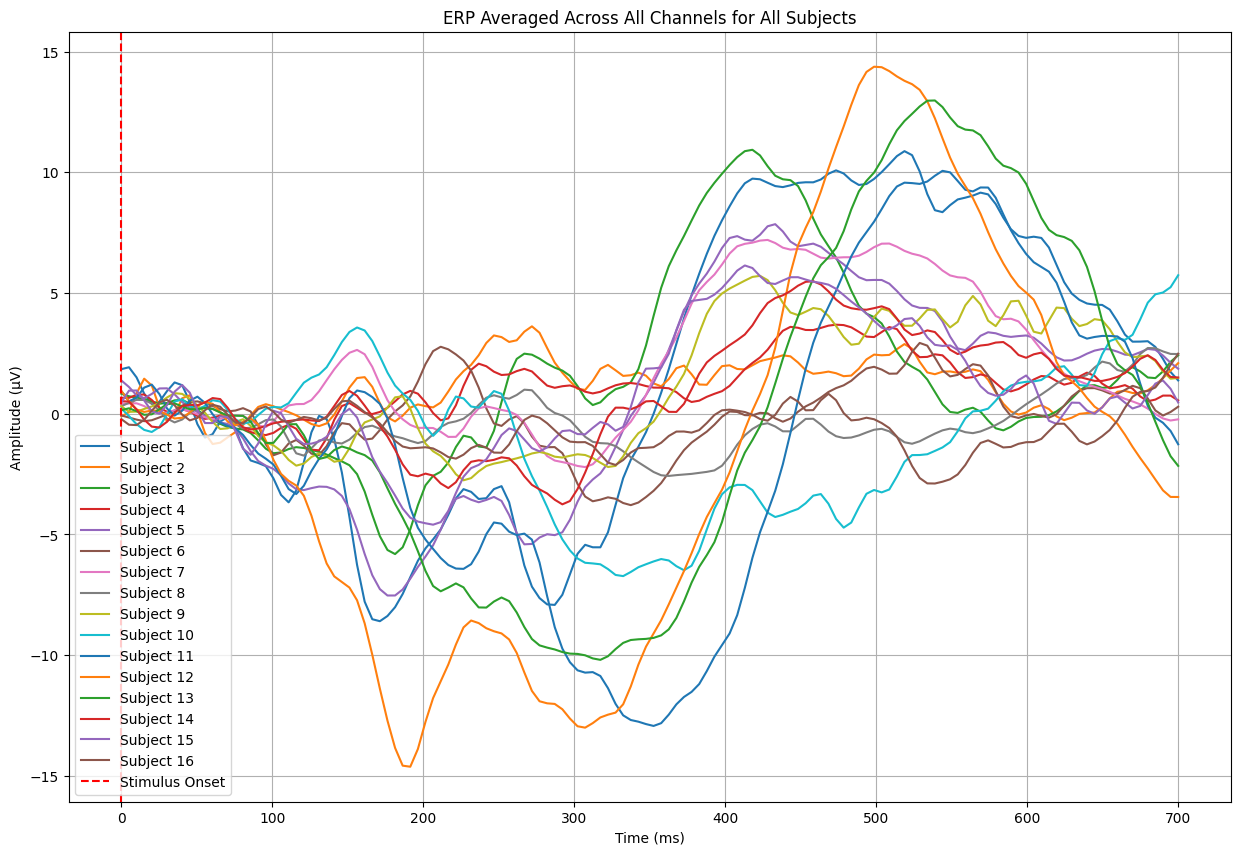

In [ ]:
train_data_list = np.load('/content/drive/My Drive/data/train_data.npy')

# Define time vector
epoch_s = 0
epoch_e = 700
epoch_len = train_data_list.shape[-1]
time = np.linspace(epoch_s, epoch_e, epoch_len)

# Plot ERP for all subjects
plt.figure(figsize=(15, 10))
for subject_id in range(train_data_list.shape[0]):
    epochs = train_data_list[subject_id]

    # Average the signal across all channels
    average_epochs = np.mean(epochs, axis=1)

    # Calculate the ERP by averaging across all epochs
    erp = np.mean(average_epochs, axis=0)

    # Plot ERP for the current subject
    plt.plot(time, erp, label=f'Subject {subject_id + 1}')

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('ERP Averaged Across All Channels for All Subjects')
plt.axvline(x=0, color='r', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.grid(True)
plt.show()

# MNE

In [ ]:
!pip install mne
import mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.5 MB/s eta 0:00:00


In [ ]:
train_data_list = np.load('/content/drive/My Drive/data/train_data.npy')

# Assuming train_data_list is of shape (subjects, epochs, channels, times)
subject_id = 0
data = train_data_list[subject_id]  # Shape: (epochs, channels, times)

# Define the sampling rate
sampling_rate = 200  # in Hz

# Create info structure
ch_names = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
            'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
            'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
            'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
            'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
            'PO7', 'POz', 'PO8', 'O1', 'O2']
ch_types = ['eeg'] * len(ch_names)

info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

# Convert data from microvolts to volts
epochs_data = data / 1e6

# Create events array, assuming each epoch is an event
events = np.array([[i, 0, 1] for i in range(epochs_data.shape[0])])

# Create MNE Epochs object
epochs = mne.EpochsArray(epochs_data, info, events)

# Plot the epochs as time series
fig = epochs.plot(show=False)  # Get the figure object

# Customize the plot
fig.subplots_adjust(top=0.9)  # Adjust the top margin to make room for the title
fig.suptitle('Epochs Time Series', fontsize=16)  # Add a title

# Customize colors
ax = fig.get_axes()[0]  # Get the first (and only) axes object
lines = ax.get_lines()
colors = plt.cm.viridis(np.linspace(0.65, 0.85, len(lines)))

for line, color in zip(lines, colors):
    line.set_color(color)

# Add grid and labels
ax.grid(True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (V)')

# Show the plot
plt.show()

NameError: name 'np' is not defined

##Plotting the power spectrum of Epochs

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


<ipython-input-24-632ddb93f61b>:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.plot_psd(fmin=0.1, fmax=40.0, ax=ax)


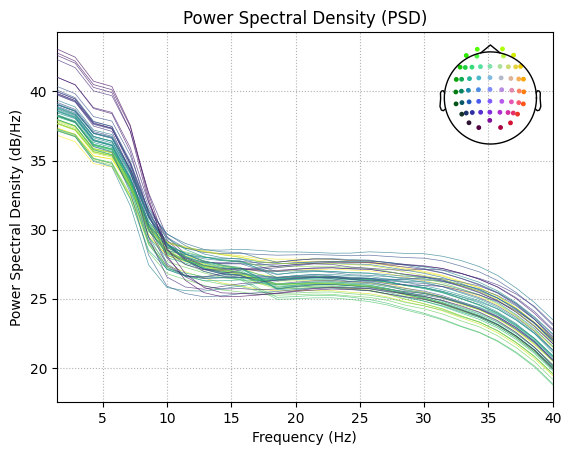

In [ ]:
fig, ax = plt.subplots()
epochs.plot_psd(fmin=0.1, fmax=40.0, ax=ax)

# Customize the colors
lines = ax.get_lines()
colors = plt.cm.viridis(np.linspace(0, 1, len(lines)))

for line, color in zip(lines, colors):
    line.set_color(color)

# Add grid and labels
ax.grid(True)
ax.set_title('Power Spectral Density (PSD)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dB/Hz)')

# Show the plot
plt.show()

##Image Map
A convenient way to visualize many epochs simultaneously is to plot them as an image map, with each row of pixels in the image representing a single epoch, the horizontal axis representing time, and each pixel’s color representing the signal value at that time sample for that epoch.

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


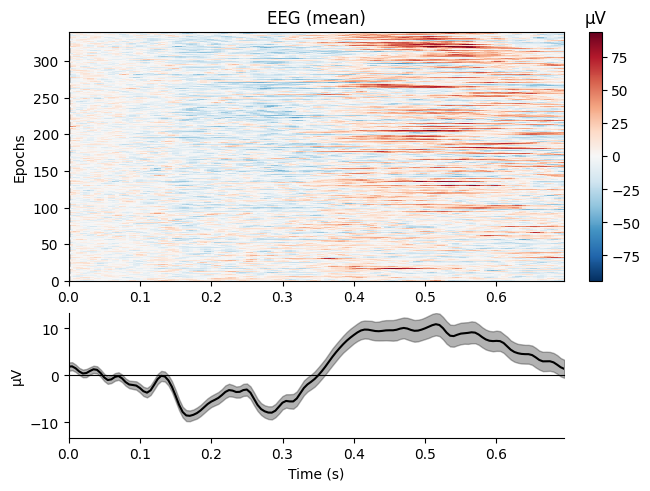

[<Figure size 640x480 with 3 Axes>]

In [ ]:
epochs.plot_image(combine='mean')

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated


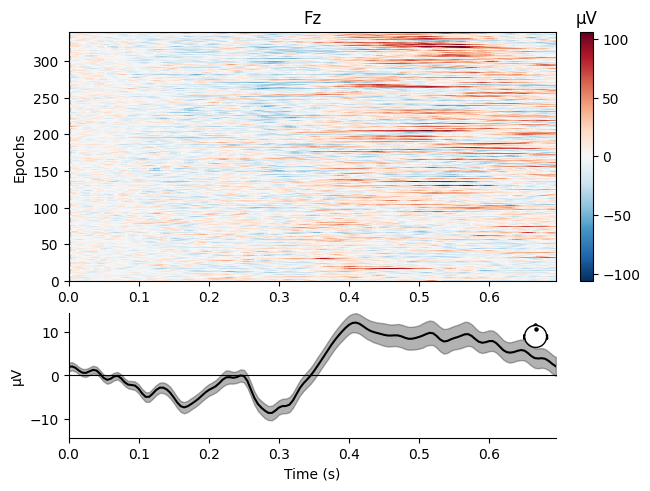

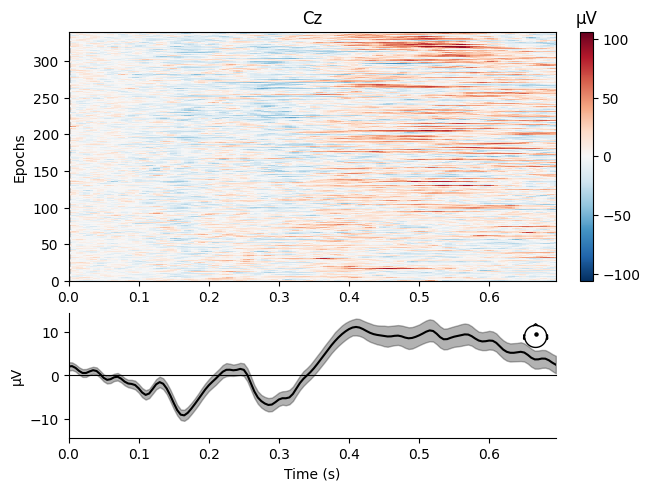

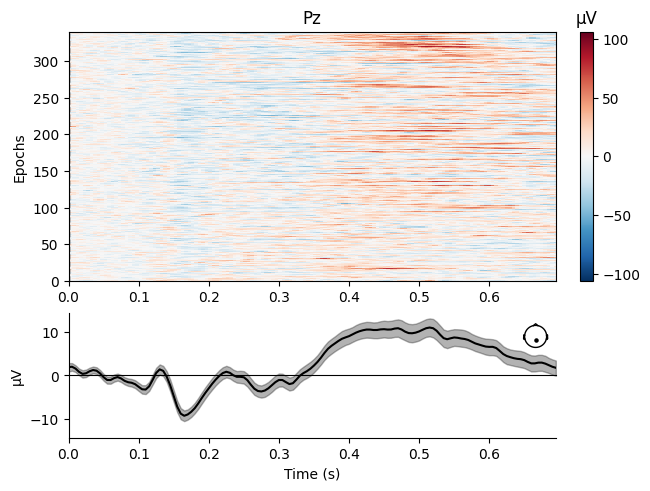

[<Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>]

In [ ]:
epochs["1"].plot_image(picks=["Fz", "Cz", "Pz"])

##Plotting sensor locations
Just like Raw objects, Epochs objects keep track of sensor locations, which can be visualized with the plot_sensors method:

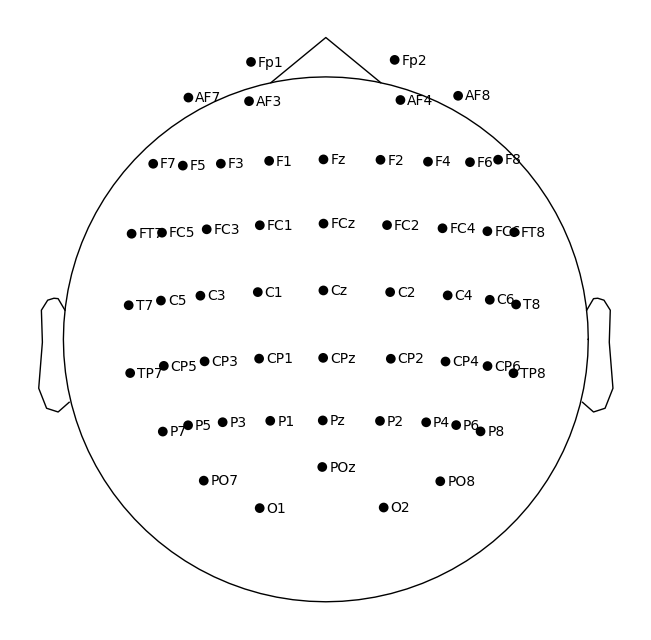

In [ ]:
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)
fig = mne.viz.plot_sensors(info, kind='topomap', show_names=True, show=False)
plt.show()

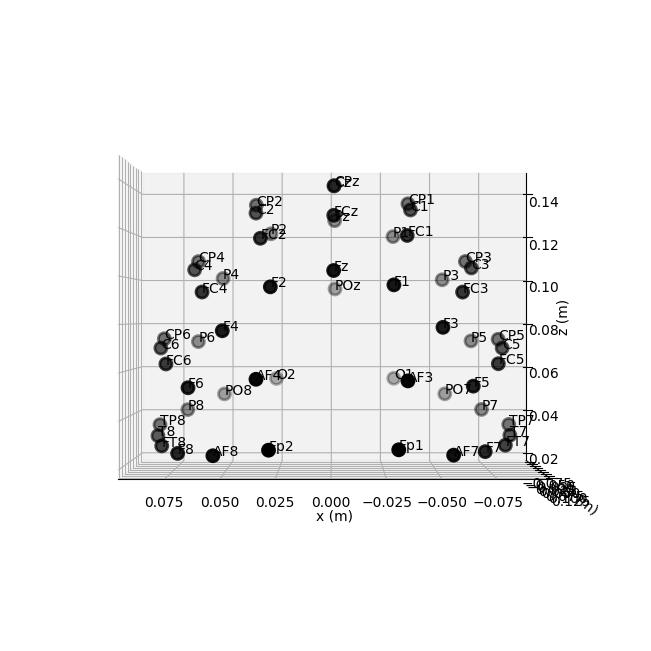

In [ ]:
fig = mne.viz.plot_sensors(info, kind='3d', show_names=True, show=False)
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated


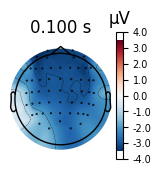

In [ ]:
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

# Apply the standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

# Convert data from microvolts to volts
epochs_data = data / 1e6  # MNE expects data in volts

# Create events array, assuming each epoch is an event
events = np.array([[i, 0, 1] for i in range(epochs_data.shape[0])])

# Create MNE Epochs object
epochs = mne.EpochsArray(epochs_data, info, events)

# Compute the average of all epochs
evoked = epochs.average()

# Plot the topomap at a specific time point (e.g., 100 ms)
time_point = 0.1  # time in seconds
fig = evoked.plot_topomap(times=[time_point], ch_type='eeg', show = False)
plt.show()

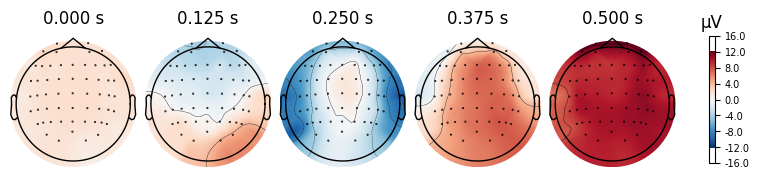

In [ ]:
times = np.linspace(0, 0.5, 5)
fig = evoked.plot_topomap(times=times, ch_type='eeg', show = False)
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


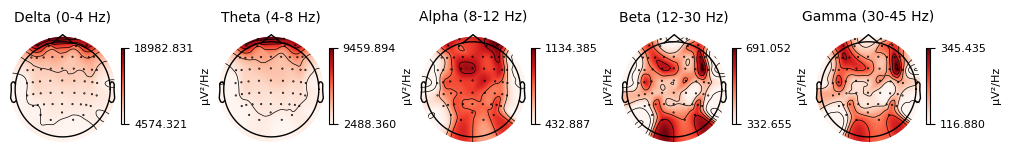

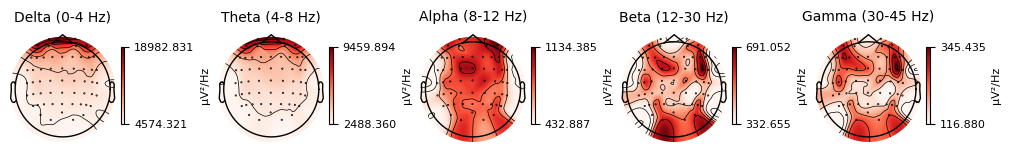

In [ ]:
epochs = mne.EpochsArray(epochs_data, info, events)

spectrum = epochs.compute_psd()

spectrum.plot_topomap()

##Magnetometers and Gradiometers

To plot an image map for all sensors, use plot_topo_image, which is optimized for plotting a large number of image maps simultaneously, and (in interactive sessions) allows you to click on each small image map to pop open a separate figure with the full-sized image plot (as if you had called plot_image on just that sensor). At the small scale shown in this tutorial it’s hard to see much useful detail in these plots; it’s often best when plotting interactively to maximize the topo image plots to fullscreen. The default is a figure with black background, so here we specify a white background and black foreground text. By default plot_topo_image will show magnetometers and gradiometers on the same plot

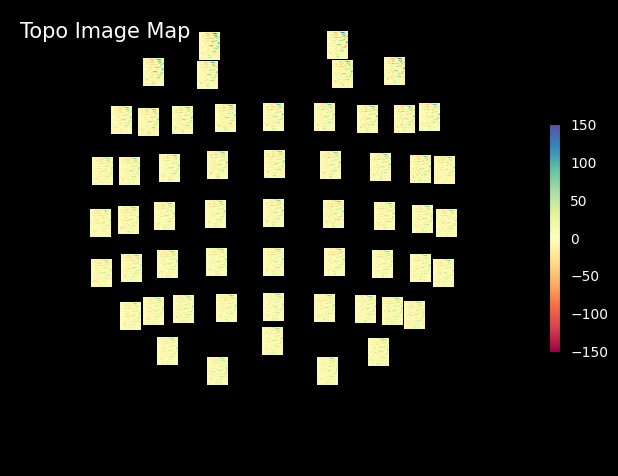

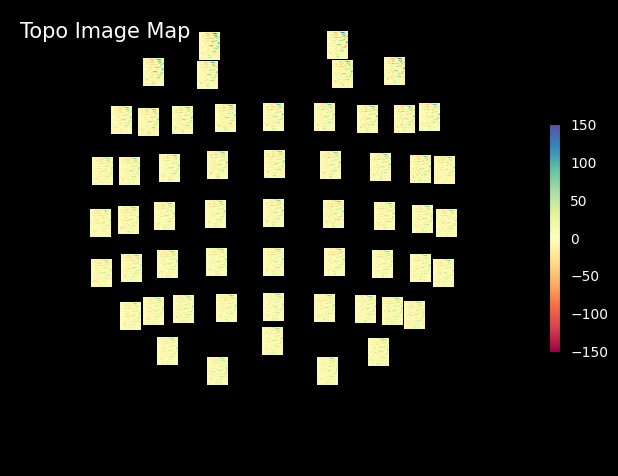

In [ ]:
epochs.plot_topo_image(cmap='Spectral', title='Topo Image Map')

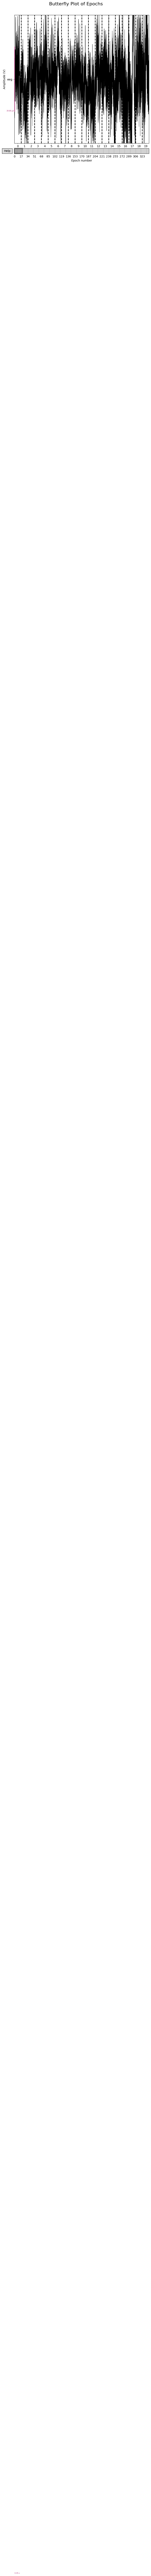

In [ ]:
fig = epochs.plot(butterfly=True, scalings='auto', picks='all', show=False)

fig.subplots_adjust(top=0.9)
fig.suptitle('Butterfly Plot of Epochs', fontsize=16)

ax = fig.get_axes()[0]
lines = ax.get_lines()
colors = plt.cm.plasma(np.linspace(0, 1, len(lines)))

ax.grid(True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (V)')

plt.show()

# TorchEEG

In [ ]:
!pip install torcheeg

In [ ]:
import torch
from torcheeg.utils import plot_raw_topomap

##Topomap :
displays the spatial distribution of electrical activity across the scalp.

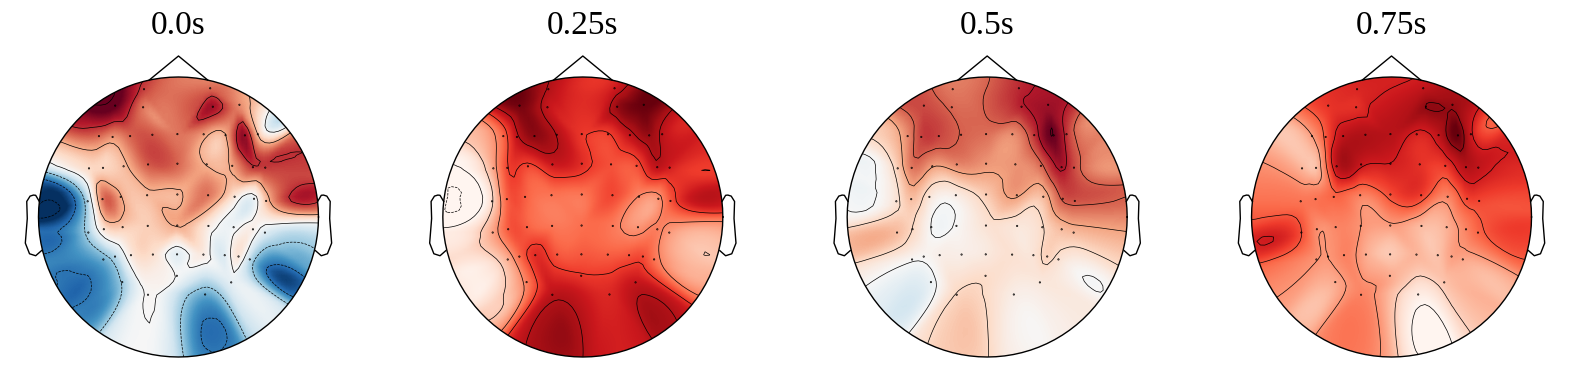

In [ ]:
CUSTOM_CHANNEL_LIST = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
                       'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
                       'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
                       'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
                       'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
                       'PO7', 'POz', 'PO8', 'O1', 'O2']

train_data_list = np.load('/content/drive/My Drive/data/train_data.npy')

# Assuming 'train_data_list' is in the shape (subjects, epochs, channels, times)
# We'll use data from the first subject and first epoch for this example
subject_id = 0
epoch_id = 0
data = train_data_list[subject_id, epoch_id]

# Convert your data to a torch tensor
# Ensure the data shape is (channels, times)
eeg_data = torch.tensor(data)

# Define the sampling rate
sampling_rate = 140

# Plot the topomap
img = plot_raw_topomap(eeg_data, channel_list=CUSTOM_CHANNEL_LIST, sampling_rate=sampling_rate)
plt.show()

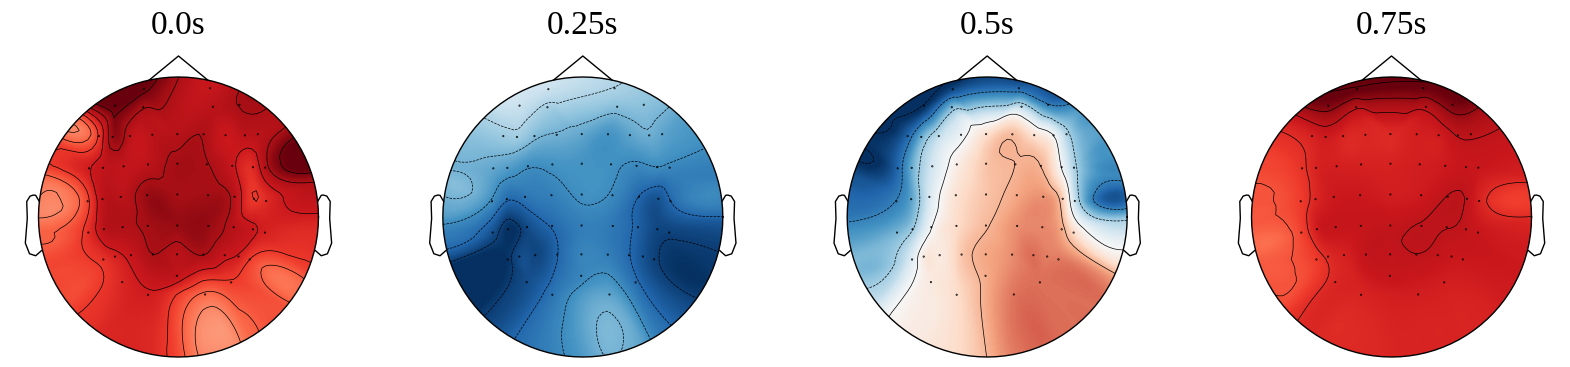

In [ ]:
average_across_epochs = np.mean(train_data_list[subject_id], axis=0)
avg_eeg_data = torch.tensor(average_across_epochs)
img = plot_raw_topomap(avg_eeg_data, channel_list=CUSTOM_CHANNEL_LIST, sampling_rate=sampling_rate)
plt.show()

##Feature Topomap
**Theta Power Topomap (4 - 8 Hz)**: Displays areas associated with drowsiness or deep relaxation  
**Alpha Power Topomap(8 - 12 Hz)**: Shows which areas of the brain are most active in the alpha frequency range, indicating regions of relaxation.  
**Beta Power Topomap(12 - 30 Hz)**: Highlights areas of active thinking and concentration.  
**Gamma Power Topomap(30 - 100 Hz)**: Illustrates regions involved in high-level cognitive processing.  


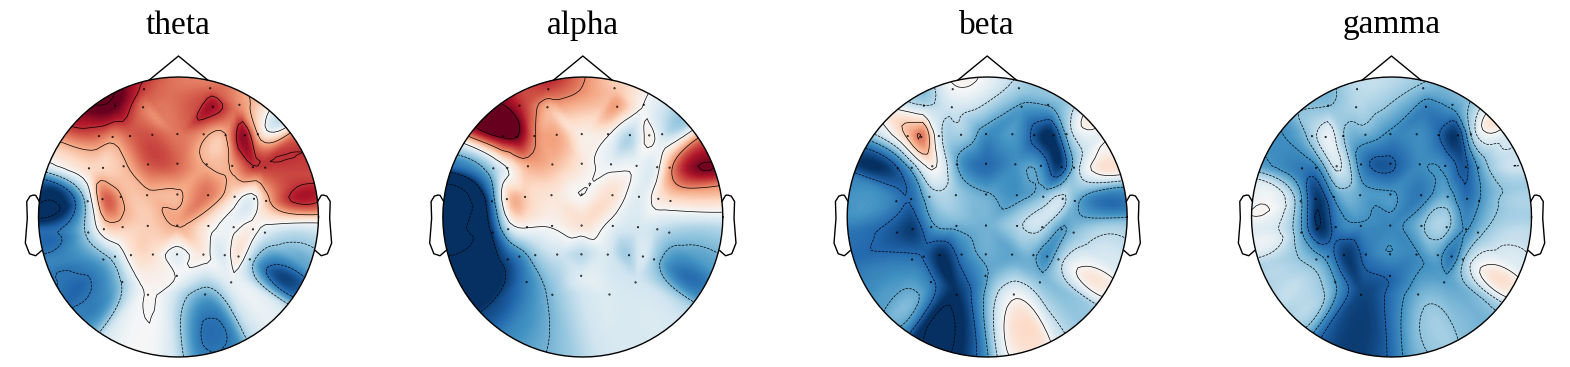

In [ ]:
from torcheeg.utils import plot_feature_topomap

img = plot_feature_topomap(eeg_data,
                 channel_list=CUSTOM_CHANNEL_LIST,
                 feature_list=["theta", "alpha", "beta", "gamma"])
plt.show()

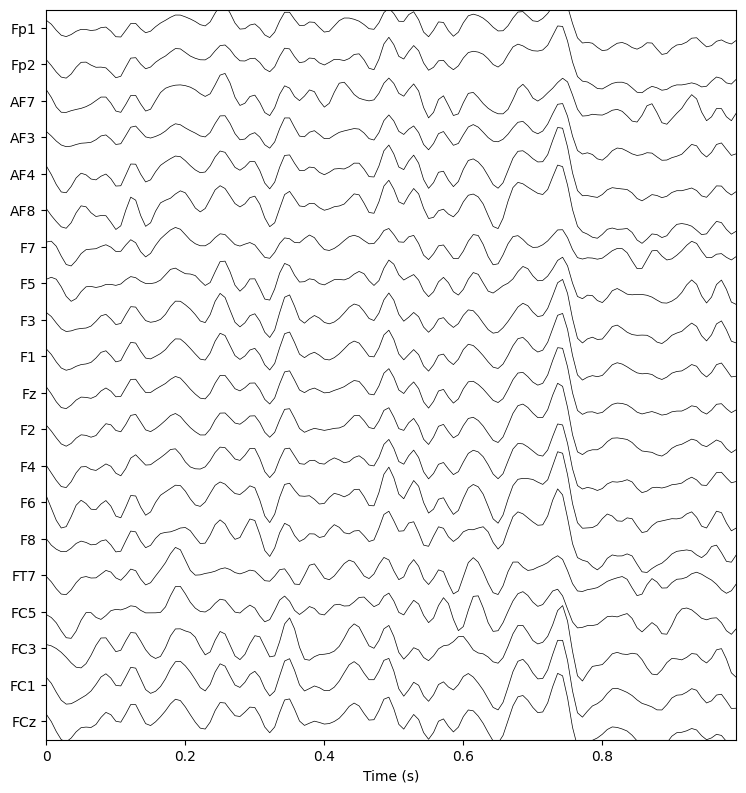

In [ ]:
from torcheeg.utils import plot_signal
img = plot_signal(eeg_data,
                  channel_list=CUSTOM_CHANNEL_LIST,
                  sampling_rate=140)

In [ ]:
from torcheeg.utils import plot_3d_tensor
subject_id = 0
data_for_subject = train_data_list[subject_id]

# Convert the reshaped data to a torch tensor
eeg_data_tensor = torch.tensor(data_for_subject)

# Now, we can plot the 3D tensor
print("Number of dimensions:", eeg_data_tensor.ndim)
print("Shape of the tensor:", eeg_data_tensor.shape)

Number of dimensions: 3
Shape of the tensor: torch.Size([340, 56, 140])


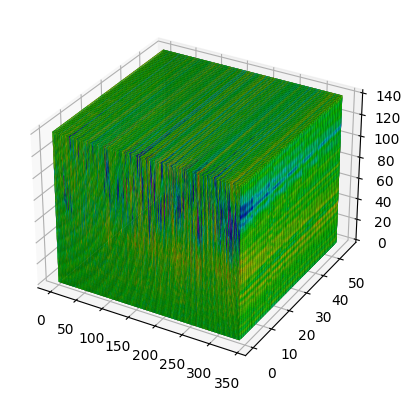

AttributeError: 'numpy.ndarray' object has no attribute 'show'

In [ ]:
img = plot_3d_tensor(eeg_data_tensor)

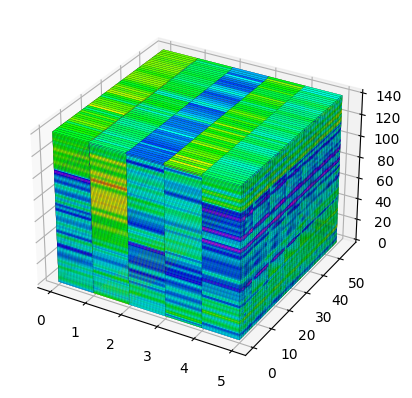

In [ ]:
from torcheeg.utils import plot_3d_tensor
subject_id = 0
data_for_subject = train_data_list[subject_id, :5, :, :]

# Convert the reshaped data to a torch tensor
eeg_data_tensor = torch.tensor(data_for_subject)

# Now, we can plot the 3D tensor
img = plot_3d_tensor(eeg_data_tensor)

In [ ]:
from torcheeg.utils import plot_2d_tensor
data = train_data_list[0, 0, :, :]
tensor_data = torch.tensor(data)
print(tensor_data.shape)

torch.Size([56, 140])


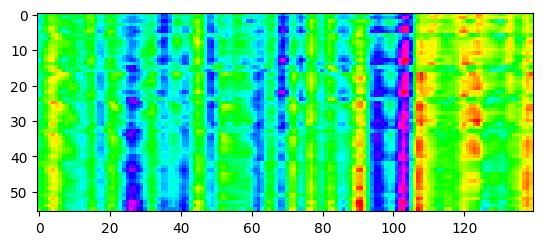

In [ ]:
img = plot_2d_tensor(tensor_data)

In [ ]:
train_data_tensor = torch.tensor(train_data_list)  # Convert NumPy array to PyTorch tensor

subject_id = 0
num_epochs = train_data_tensor.shape[1]
num_times = train_data_tensor.shape[3]

# Compute the mean across the channels dimension for each epoch at each time point
mean_data = torch.mean(train_data_tensor[subject_id], dim=1)  # Mean across the channels dimension

# Reshape the mean_data to a 2D array
mean_data_2d = mean_data.view(num_epochs, num_times)

# Convert to a NumPy array if needed
data = mean_data_2d.numpy()
data = data.T
tensor_data = torch.tensor(data)
print(tensor_data.shape)

torch.Size([140, 340])


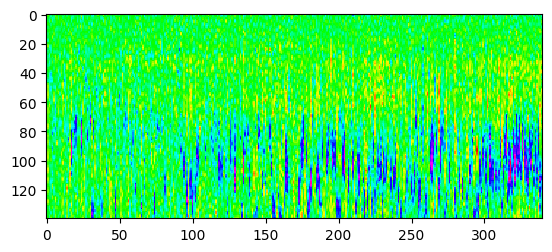

In [ ]:
plt = plot_2d_tensor(tensor_data)